<a href="https://colab.research.google.com/github/ebzkurt1/ml_with_jax/blob/main/Perceptron_using_Jax_Library.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import numpy as np
import jax
from jax import random
import jax.numpy as jnp
from jax import grad, jit, vmap
import matplotlib.pyplot as plt

In [2]:
# X = jnp.array([[3.0,1.2,3.6],[1.4,6.21,6.8],[1.4,67.3,8.9],[1.4,2.6,1.6]])
X = random.normal(key=random.PRNGKey(42),shape=(10,4))
# y = jnp.array([[1],[2],[3],[2]])
y = jnp.array(
    [
     [0],[0],[2],[1],[2],[0],[1],[2],[2],[1]
    ]
)
class_num = 3
# W = random.normal(key=random.PRNGKey(42),shape=(X.shape[-1],class_num))
# b = random.normal(key=random.PRNGKey(42),shape=(class_num,1))
# print(b)
# print(jnp.matmul(X,W))
# ff = (jnp.matmul(X,W).T + b).T
# pred = jnp.exp(ff)/jnp.exp(ff).sum(axis=0)
# pred_arg = jnp.argmax(pred,axis=1).reshape(-1,1)
# print(pred_arg)

In [16]:
def custom_sigmoid(matrix):
    return (1/(1+jnp.exp(-matrix)))

def custom_softmax(matrix):
    return jnp.exp(matrix)/jnp.sum(jnp.exp(matrix),axis=1).reshape(-1,1)

def forward_pass(X, W, b, activation):
    return activation((jnp.matmul(X, W).T + b).T)

def categorical_cross_entropy(yhat,y):
    return -jnp.sum(y*jnp.log(yhat))

# def feed_forward(X, Y, W, b, activation):
#     Yhat = forward_pass(X,W,b)
#     Yhat = activation(Yhat)
#     categorical_pred = (jnp.argmax(Yhat,axis=1) + 1).reshape(-1,1)
#     return categorical_pred

def loss(X,Y,W,b,loss_fnc, activation):
    Yhat = forward_pass(X,W,b,activation)
    return loss_fnc(Yhat,Y)

fwd = forward_pass(X,W,b,custom_softmax)
act = custom_softmax(fwd)
prd = (jnp.argmax(act,axis=1)+1).reshape(-1,1)
lss = categorical_cross_entropy(prd,y)
# ff = feed_forward(X,y,W,b,custom_softmax)
# print((categorical_cross_entropy(ff,y)))

W_grad = grad(loss,argnums=2)(X,y,W,b,categorical_cross_entropy,custom_softmax)
print('W_grad', W_grad)
b_grad = grad(loss,argnums=3)(X,y,W,b,categorical_cross_entropy,custom_softmax)
print("b_grad",b_grad)

W_grad [[ 8.03366   -5.8095484 -2.2241096]
 [ 6.8415346 -6.1532435 -0.6882926]
 [10.902298  -3.7077832 -7.194514 ]
 [-2.7530346  3.1355824 -0.3825494]]
b_grad [[10.114142 ]
 [-1.3245295]
 [-8.789612 ]]


In [152]:
class Perceptron:
    def __init__(self, class_num=1, activation_func='sigmoid', loss_func='mean_squared_error', learning_rate=0.01, iter=50, random_key=1):
        self.class_num = class_num
        self.activation_func = activation_func
        self.loss_func = loss_func
        self.learning_rate = learning_rate
        self.iter = iter
        self.random_key = random.PRNGKey(random_key)

    def initialize_weights(self, X):
        self.W = random.normal(
            key=self.random_key,
            shape=(X.shape[-1],self.class_num)
        )
        self.b = random.normal(
            key=self.random_key,
            shape=(self.class_num,1)
        )

    def forward(self, X):
        return (jnp.matmul(X, self.W).T + self.b).T

    def softmax_func(self, matrix):
        return jnp.exp(matrix)/jnp.sum(jnp.exp(matrix),axis=1).reshape(-1,1)

    def sigmoid_func(self, matrix):
        return (1/(1+jnp.exp(-matrix)))

    def jax_sigmoid(self, matrix):
        return jax.nn.sigmoid(matrix)
    
    def mean_squared_error(self, Yhat, Y):
        return jnp.mean((Yhat-Y)**2)
        
    def categorical_cross_entropy(self, Yhat, Y):
        return -jnp.sum(Y*jnp.log(Yhat))
    
    def forward_step(self, X, W, b):
        if self.activation_func == 'sigmoid':
            return self.sigmoid_func((jnp.matmul(X, W).T + b).T)
        elif self.activation_func == 'softmax':
            # print("IN FORWARD \n",((jnp.matmul(X, W).T + b).T))
            print("WITH THE SOFT \n",jax.nn.softmax((jnp.matmul(X, W).T + b).T))
            # return self.softmax_func((jnp.matmul(X, W).T + b).T)
            return jax.nn.softmax((jnp.matmul(X, W).T + b).T)
        else:
            return (jnp.matmul(X, W).T + b).T
    
    def loss(self, X, Y, W, b):
        # print(X.shape,Y.shape,W.shape,b.shape)
        Yhat = self.forward_step(X,W,b)
        # print("In loss function \n",Yhat)
        if self.loss_func == 'mean_squared_error':
            return self.mean_squared_error(Yhat, Y)
        elif self.loss_func == 'categorical_cross_entropy':
            return self.categorical_cross_entropy(Yhat,Y)

    def param_update(self, w_gradient, b_gradient):
        self.W -= self.learning_rate * w_gradient
        self.b -= self.learning_rate * b_gradient
    
    def predict(self, X):
        return jnp.argmax(self.forward_step(X,self.W,self.b),axis=1)

    def fit(self, X, Y):
        self.history = {
            'loss':[],
            'accuracy':[]
        }
        self.initialize_weights(X)
        for i in range(self.iter):
            # print(X,Y,self.W,self.b)
            step_loss = self.loss(X, Y, self.W, self.b)
            # print(step_loss)
            step_prediction = self.predict(X).reshape(-1,1)
            step_accuracy = (((step_prediction==Y).sum())/X.shape[0])*100
            self.history['accuracy'].append(step_accuracy)
            self.history['loss'].append(step_loss)
            W_grad = grad(self.loss,argnums=2)(X,Y,self.W,self.b)
            b_grad = grad(self.loss,argnums=3)(X,Y,self.W,self.b)
            self.param_update(W_grad,b_grad)
            print("Epoch",i,"accuracy :",step_accuracy)
            # print(step_loss)
            # print(W_grad)
            # print(b_grad)
            # print(self.W)
        return self.history

In [48]:
perceptron_model = Perceptron(
    class_num=class_num,
    activation_func='softmax',
    loss_func='categorical_cross_entropy',
)

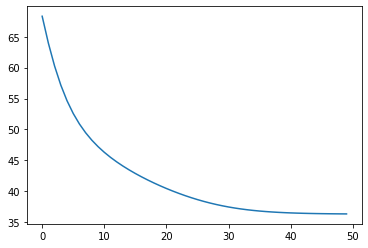

In [49]:
model_history = perceptron_model.fit(X,y)
plt.plot(model_history['loss'])

In [35]:
from keras.datasets import mnist
(train_X, train_Y), (test_X, test_Y) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [57]:
print("Train X shapes : ", train_X.shape, type(train_X))
print("Train Y shapes : ", train_Y.shape, type(train_Y))
print("Test X shapes : ", test_X.shape, type(test_X))
print("Test Y shapes : ", test_Y.shape, type(test_Y))

flat_train_X = jnp.asarray(train_X).reshape(-1,28*28)
flat_norm_train_X = flat_train_X/255.0
flat_train_Y = jnp.asarray(train_Y).reshape(-1,1)


flat_test_X = jnp.asarray(test_X).reshape(-1,28*28)
flat_norm_test_X = flat_test_X/255.0
flat_test_Y = jnp.asarray(test_Y).reshape(-1,1)

print("Processed Train X shapes : ", flat_norm_train_X.shape, type(flat_norm_train_X))
print("Processed Train Y shapes : ", flat_train_Y.shape, type(flat_train_Y))
print("Processed Test X shapes : ", flat_norm_test_X.shape, type(flat_norm_test_X))
print("Processed Test Y shapes : ", flat_test_Y.shape, type(flat_test_Y))

Train X shapes :  (60000, 28, 28) <class 'numpy.ndarray'>
Train Y shapes :  (60000,) <class 'numpy.ndarray'>
Test X shapes :  (10000, 28, 28) <class 'numpy.ndarray'>
Test Y shapes :  (10000,) <class 'numpy.ndarray'>
Processed Train X shapes :  (60000, 784) <class 'jaxlib.xla_extension.DeviceArray'>
Processed Train Y shapes :  (60000, 1) <class 'jaxlib.xla_extension.DeviceArray'>
Processed Test X shapes :  (10000, 784) <class 'jaxlib.xla_extension.DeviceArray'>
Processed Test Y shapes :  (10000, 1) <class 'jaxlib.xla_extension.DeviceArray'>


In [155]:
mnist_perceptron_model = Perceptron(
    class_num=10,
    activation_func='softmax',
    loss_func='categorical_cross_entropy',
    iter=3
)

WITH THE SOFT 
 [[6.41975999e-02 7.72180375e-14 4.40844923e-01 ... 7.25509149e-12
  3.33175086e-03 2.19234789e-06]
 [1.12821253e-05 4.41953924e-15 2.73078695e-12 ... 1.67155872e-12
  5.13250828e-02 4.23662883e-09]
 [5.91588056e-10 1.31975125e-11 4.27631810e-16 ... 7.81825861e-07
  2.30332850e-10 2.73715359e-05]
 ...
 [1.20018827e-04 6.17792661e-09 3.30750964e-07 ... 4.33711648e-05
  1.53182792e-02 2.73711365e-08]
 [3.71682213e-10 4.85025253e-16 5.07619077e-12 ... 6.21370873e-07
  2.71865545e-04 4.64026018e-09]
 [2.05249432e-13 1.14529432e-15 2.50863080e-10 ... 6.78584272e-11
  1.15804432e-04 2.59300936e-08]]
WITH THE SOFT 
 [[6.41975999e-02 7.72180375e-14 4.40844923e-01 ... 7.25509149e-12
  3.33175086e-03 2.19234789e-06]
 [1.12821253e-05 4.41953924e-15 2.73078695e-12 ... 1.67155872e-12
  5.13250828e-02 4.23662883e-09]
 [5.91588056e-10 1.31975125e-11 4.27631810e-16 ... 7.81825861e-07
  2.30332850e-10 2.73715359e-05]
 ...
 [1.20018827e-04 6.17792661e-09 3.30750964e-07 ... 4.33711648e-05


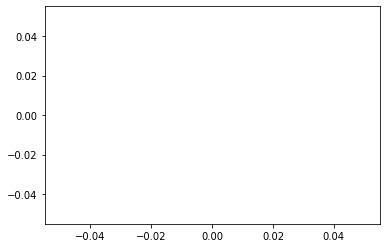

In [156]:
mnist_history = mnist_perceptron_model.fit(flat_norm_train_X,flat_train_Y)
plt.plot(model_history['accuracy'])

In [107]:
mnist_perceptron_model.W

DeviceArray([[nan, nan, nan, ..., nan, nan, nan],
             [nan, nan, nan, ..., nan, nan, nan],
             [nan, nan, nan, ..., nan, nan, nan],
             ...,
             [nan, nan, nan, ..., nan, nan, nan],
             [nan, nan, nan, ..., nan, nan, nan],
             [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)